# Deep CTR (Attention and Self-attention)

In [25]:
import numpy as np
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from deepctr_torch.models import DeepFM
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score,
    roc_auc_score,
    log_loss,
)
import sklearn

In [95]:
# pass in column names for each CSV
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('C:\\Users\\Lina\\ml-100k\\ml-100k\\u.user', sep='|', names=u_cols)

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('C:\\Users\\Lina\\ml-100k\\ml-100k\\u.data', sep='\t', names=r_cols)

# the movies file contains columns indicating the movie's genres
# let's only load the first five columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date', 'imdb_url']
movies = pd.read_csv('C:\\Users\\Lina\\ml-100k\\ml-100k\\u.item', sep='|', names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 
                                                  'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
                                                  'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                                                  'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
                     dtype={'release_date': "S100", 'imdb_url': "S200"},encoding='ansi')
genres = ['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
          'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
          'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies['genre'] = movies[genres].idxmax(1)
#movies = movies.drop(genres, axis=1)
genres_encoder = sklearn.preprocessing.MultiLabelBinarizer()
movies['genre'] = genres_encoder.fit_transform(
        movies['genre'].apply(lambda s: s.split("|"))
    ).tolist()
    
# create one merged DataFrame
movie_ratings = pd.merge(movies[['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL','genre']], ratings)
data = pd.merge(movie_ratings, users)
data.head()
data.to_csv('data.csv')

In [56]:
import torch
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from deepctr_torch.inputs import SparseFeat, get_feature_names
from deepctr_torch.models import DeepFM

sparse_features = ["movie_id", "user_id",
                       "sex", "age", "occupation", "zip_code"]
target = ['rating']

    # 1.Label Encoding for sparse features,and do simple Transformation for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
    # 2.count #unique features for each sparse field
fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique())
                              for feat in sparse_features]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

    # 3.generate input data for model
train, test = train_test_split(data, test_size=0.25,random_state=np.random.seed(42))
train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}
    # 4.Define Model,train,predict and evaluate

device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression', device=device)
model.compile("adam", "mse", metrics=['mse'], )
history = model.fit(train_model_input, train[target].values,
                        batch_size=256, epochs=50, verbose=2, validation_split=0.2)

pred_ans = model.predict(test_model_input, batch_size=256)
rmse=math.sqrt(round(mean_squared_error(test[target].values, pred_ans), 4))
print("test RMSE",rmse )



cpu
Train on 60000 samples, validate on 15000 samples, 235 steps per epoch
Epoch 1/50
7s - loss:  2.0841 - mse:  2.0813 - val_mse:  0.9316
Epoch 2/50
7s - loss:  0.8804 - mse:  0.8803 - val_mse:  0.9137
Epoch 3/50
8s - loss:  0.8602 - mse:  0.8597 - val_mse:  0.9094
Epoch 4/50
8s - loss:  0.8546 - mse:  0.8543 - val_mse:  0.9092
Epoch 5/50
9s - loss:  0.8518 - mse:  0.8520 - val_mse:  0.9079
Epoch 6/50
9s - loss:  0.8491 - mse:  0.8487 - val_mse:  0.9088
Epoch 7/50
8s - loss:  0.8475 - mse:  0.8471 - val_mse:  0.9109
Epoch 8/50
8s - loss:  0.8468 - mse:  0.8466 - val_mse:  0.9075
Epoch 9/50
8s - loss:  0.8452 - mse:  0.8455 - val_mse:  0.9105
Epoch 10/50
8s - loss:  0.8444 - mse:  0.8444 - val_mse:  0.9107
Epoch 11/50
8s - loss:  0.8429 - mse:  0.8426 - val_mse:  0.9220
Epoch 12/50
8s - loss:  0.8420 - mse:  0.8425 - val_mse:  0.9099
Epoch 13/50
8s - loss:  0.8417 - mse:  0.8416 - val_mse:  0.9134
Epoch 14/50
8s - loss:  0.8406 - mse:  0.8400 - val_mse:  0.9114
Epoch 15/50
8s - loss:  

In [62]:
train.to_csv('train.csv')

In [57]:
train

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,genre,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
98980,267,Chasing Amy (1997),b'01-Jan-1997',NaN,http://us.imdb.com/M/title-exact?Chasing+Amy+(...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",46,4,879439040,43,1,11,72
69824,584,Son in Law (1993),b'01-Jan-1993',NaN,http://us.imdb.com/M/title-exact?Son%20in%20La...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",845,2,883949643,17,1,9,355
9928,214,Field of Dreams (1989),b'01-Jan-1989',NaN,http://us.imdb.com/M/title-exact?Field%20of%20...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",22,2,874787116,20,0,1,364
75599,87,Sleepless in Seattle (1993),b'01-Jan-1993',NaN,http://us.imdb.com/M/title-exact?Sleepless%20i...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",757,4,881979942,17,1,18,402
95621,1627,Lamerica (1994),b'01-Jan-1994',NaN,http://us.imdb.com/M/title-exact?Lamerica%20(1...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",674,5,889489837,24,1,13,240
80724,1060,"Evening Star, The (1996)",b'25-Dec-1996',NaN,http://us.imdb.com/M/title-exact?Evening%20Sta...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",589,2,879439538,40,1,3,597
78925,735,Shadowlands (1993),b'01-Jan-1993',NaN,http://us.imdb.com/M/title-exact?Shadowlands%2...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",269,5,876955087,8,0,18,498
14672,202,Unforgiven (1992),b'01-Jan-1992',NaN,http://us.imdb.com/M/title-exact?Unforgiven%20...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",83,3,883453587,22,1,6,433
76016,126,"Godfather, The (1972)",b'01-Jan-1972',NaN,"http://us.imdb.com/M/title-exact?Godfather,%20...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",628,5,880117605,36,0,13,339
95628,312,Titanic (1997),b'01-Jan-1997',NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",913,3,887121969,34,0,13,79


In [63]:
test.to_csv('test.csv')

In [100]:
def metrics(data_true, data_pred):
    mse=np.sqrt(mean_squared_error(data_true, data_pred))
    mae=mean_absolute_error(data_true, data_pred)
    r2=r2_score(data_true, data_pred)
    ex_var=explained_variance_score(data_true, data_pred)
    df=pd.DataFrame({"RMSE": mse, "MAE":mae, "R2_score":r2, "explained variance":ex_var},index=[0])
    return df

metrics(test[target].values, pred_ans)

,RMSE,MAE,R2_score,explained variance
0,0.945507,0.74331,0.29929,0.30029


___________________________________________________________________________

# Autoencoders

In [25]:
## -*- coding: utf-8 -*-

#ratings-u.data df
#movies-u.item movie_df

In [101]:
data.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,genre,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
0,1,Toy Story (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",308,4,887738847,60,M,retired,95076
4,8,Babe (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",308,5,887736696,60,M,retired,95076


In [102]:
# capture all genre columns, get them to one column, remove them after it is done
genres = ['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
          'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
          'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies['genre'] = movies[genres].idxmax(1)
movies = movies.drop(genres, axis=1)
movies.head(5)

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,genre
0,1,Toy Story (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,Animation
1,2,GoldenEye (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,Action
2,3,Four Rooms (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,Thriller
3,4,Get Shorty (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,Action
4,5,Copycat (1995),b'01-Jan-1995',NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),Crime


In [103]:
movies = movies[['movie_id', 'movie_title', 'release_date', 'IMDb_URL', 'genre']]

In [104]:
movies.head(5)

,movie_id,movie_title,release_date,IMDb_URL,genre
0,1,Toy Story (1995),b'01-Jan-1995',http://us.imdb.com/M/title-exact?Toy%20Story%2...,Animation
1,2,GoldenEye (1995),b'01-Jan-1995',http://us.imdb.com/M/title-exact?GoldenEye%20(...,Action
2,3,Four Rooms (1995),b'01-Jan-1995',http://us.imdb.com/M/title-exact?Four%20Rooms%...,Thriller
3,4,Get Shorty (1995),b'01-Jan-1995',http://us.imdb.com/M/title-exact?Get%20Shorty%...,Action
4,5,Copycat (1995),b'01-Jan-1995',http://us.imdb.com/M/title-exact?Copycat%20(1995),Crime


In [105]:
# Creating a sparse pivot table with users in rows and items in columns
users_items_matrix_df = data.pivot(index   = 'user_id', 
                                 columns = 'movie_id', 
                                 values  = 'rating').fillna(0)
users_items_matrix_df.head(10)

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
users_items_matrix_df.shape

(943, 1682)

In [107]:
users_items_matrix_df.values.mean()*100

22.254600202001605

In [108]:
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model

def autoEncoder(X):
    '''
    Autoencoder for Collaborative Filter Model
    '''

    # Input
    input_layer = Input(shape=(X.shape[1],), name='UserScore')
    
    # Encoder
    # -----------------------------
    enc = Dense(512, activation='selu', name='EncLayer1')(input_layer)

    # Latent Space
    # -----------------------------
    lat_space = Dense(256, activation='selu', name='LatentSpace')(enc)
    lat_space = Dropout(0.8, name='Dropout')(lat_space) # Dropout

    # Decoder
    # -----------------------------
    dec = Dense(512, activation='selu', name='DecLayer1')(lat_space)

    # Output
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred')(dec)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)    
    
    return model

In [109]:
# input
X = users_items_matrix_df.values
y = users_items_matrix_df.values

In [110]:
# Build model
model = autoEncoder(X)

model.compile(optimizer = Adam(lr=0.0001), loss='mse')
    
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserScore (InputLayer)       (None, 1682)              0         
_________________________________________________________________
EncLayer1 (Dense)            (None, 512)               861696    
_________________________________________________________________
LatentSpace (Dense)          (None, 256)               131328    
_________________________________________________________________
Dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
DecLayer1 (Dense)            (None, 512)               131584    
_________________________________________________________________
UserScorePred (Dense)        (None, 1682)              862866    
Total params: 1,987,474
Trainable params: 1,987,474
Non-trainable params: 0
_________________________________________________________________


In [111]:
hist = model.fit(x=X, y=y,
                  epochs=50,
                  batch_size=64,
                  shuffle=True,
                  validation_split=0.15)

Train on 801 samples, validate on 142 samples
Epoch 1/50
801/801 [==============================] - ETA: 9s - loss: 2.114 - ETA: 4s - loss: 2.169 - ETA: 2s - loss: 2.212 - ETA: 2s - loss: 2.186 - ETA: 1s - loss: 2.222 - ETA: 1s - loss: 2.257 - ETA: 0s - loss: 2.229 - ETA: 0s - loss: 2.196 - ETA: 0s - loss: 2.203 - ETA: 0s - loss: 2.189 - ETA: 0s - loss: 2.160 - ETA: 0s - loss: 2.155 - 2s 2ms/step - loss: 2.1510 - val_loss: 1.1308
Epoch 2/50
801/801 [==============================] - ETA: 0s - loss: 2.016 - ETA: 0s - loss: 1.971 - ETA: 0s - loss: 1.901 - ETA: 0s - loss: 1.939 - ETA: 0s - loss: 1.909 - ETA: 0s - loss: 1.925 - ETA: 0s - loss: 1.921 - ETA: 0s - loss: 1.895 - ETA: 0s - loss: 1.870 - ETA: 0s - loss: 1.858 - ETA: 0s - loss: 1.868 - ETA: 0s - loss: 1.856 - 1s 1ms/step - loss: 1.8555 - val_loss: 1.0816
Epoch 3/50
801/801 [==============================] - ETA: 0s - loss: 1.636 - ETA: 0s - loss: 1.710 - ETA: 0s - loss: 1.762 - ETA: 0s - loss: 1.776 - ETA: 0s - loss: 1.772 - ETA:

Epoch 22/50
801/801 [==============================] - ETA: 0s - loss: 0.788 - ETA: 0s - loss: 0.800 - ETA: 0s - loss: 0.846 - ETA: 0s - loss: 0.843 - ETA: 0s - loss: 0.823 - ETA: 0s - loss: 0.830 - ETA: 0s - loss: 0.829 - ETA: 0s - loss: 0.830 - ETA: 0s - loss: 0.829 - ETA: 0s - loss: 0.840 - ETA: 0s - loss: 0.848 - ETA: 0s - loss: 0.829 - 1s 1ms/step - loss: 0.8248 - val_loss: 0.6225
Epoch 23/50
801/801 [==============================] - ETA: 0s - loss: 0.794 - ETA: 0s - loss: 0.843 - ETA: 0s - loss: 0.846 - ETA: 0s - loss: 0.824 - ETA: 0s - loss: 0.824 - ETA: 0s - loss: 0.833 - ETA: 0s - loss: 0.818 - ETA: 0s - loss: 0.817 - ETA: 0s - loss: 0.814 - ETA: 0s - loss: 0.814 - ETA: 0s - loss: 0.810 - ETA: 0s - loss: 0.811 - 1s 1ms/step - loss: 0.8090 - val_loss: 0.6178
Epoch 24/50
801/801 [==============================] - ETA: 0s - loss: 0.776 - ETA: 0s - loss: 0.793 - ETA: 0s - loss: 0.802 - ETA: 0s - loss: 0.806 - ETA: 0s - loss: 0.789 - ETA: 0s - loss: 0.788 - ETA: 0s - loss: 0.791 -

801/801 [==============================] - ETA: 0s - loss: 0.607 - ETA: 0s - loss: 0.616 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.635 - ETA: 0s - loss: 0.645 - ETA: 0s - loss: 0.659 - ETA: 0s - loss: 0.655 - ETA: 0s - loss: 0.638 - ETA: 0s - loss: 0.636 - ETA: 0s - loss: 0.632 - ETA: 0s - loss: 0.632 - ETA: 0s - loss: 0.632 - 1s 1ms/step - loss: 0.6364 - val_loss: 0.5412
Epoch 44/50
801/801 [==============================] - ETA: 0s - loss: 0.623 - ETA: 0s - loss: 0.638 - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.629 - ETA: 0s - loss: 0.632 - ETA: 0s - loss: 0.625 - ETA: 0s - loss: 0.640 - ETA: 0s - loss: 0.635 - ETA: 0s - loss: 0.637 - ETA: 0s - loss: 0.638 - ETA: 0s - loss: 0.636 - ETA: 0s - loss: 0.636 - 1s 1ms/step - loss: 0.6345 - val_loss: 0.5392
Epoch 45/50
801/801 [==============================] - ETA: 0s - loss: 0.581 - ETA: 0s - loss: 0.618 - ETA: 0s - loss: 0.609 - ETA: 0s - loss: 0.609 - ETA: 0s - loss: 0.626 - ETA: 0s - loss: 0.623 - ETA: 0s - loss: 0.623 - ETA: 0s - l

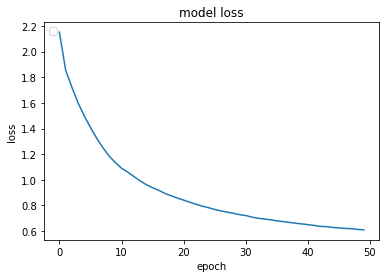

In [112]:
def plot_hist(hist):
    # summarize history for loss
    fig, ax = plt.subplots()  # create figure & 1 axis

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.plot(hist.history['loss'])
    #plt.plot(hist.history['val_loss'])

plot_hist(hist)

In [113]:
# Predict new Matrix Interactions, set score zero on visualized movies
new_matrix = model.predict(X) * (X == 0)

In [114]:
new_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.1071421 ,
         0.04840432, -0.31022456],
       [ 0.        , -0.4080746 ,  0.40681046, ..., -0.05665429,
         0.06478442, -0.14926422],
       [ 0.5008088 ,  0.17744562,  0.00802451, ..., -0.06561836,
         0.2054483 , -0.14836362],
       ...,
       [ 0.        ,  0.4009295 ,  0.3708753 , ...,  0.14916535,
         0.20857942,  0.06849397],
       [ 1.6416347 , -0.18824916, -0.25908697, ..., -0.17986615,
         0.03735149, -0.13279507],
       [ 3.1961954 ,  0.        ,  0.64655566, ...,  0.03389197,
         0.19677597,  0.07447936]], dtype=float32)

In [115]:
metrics(X, new_matrix)

,RMSE,MAE,R2_score,explained variance
0,1.001251,0.421818,-0.72727,-0.663955
